In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
origin_data = -1. + 0.5 * torch.randn(100)
fake_data = 1. + 0.5 * torch.randn(100)

/Users/SungYub/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


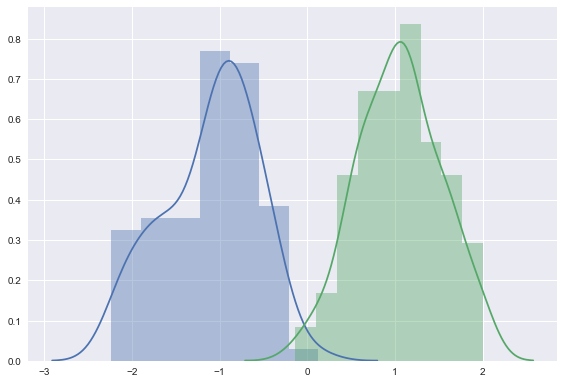

In [3]:
sns.distplot(origin_data)
sns.distplot(fake_data)
plt.tight_layout()
plt.show()

In [4]:
class D(nn.Module):
    def __init__(self, hidden_dim=1024, latent_dim=256, num_latent=1):
        super(D, self).__init__()
        self.fc1 = nn.Linear(1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.constant_(self.fc3.bias, 0.0)
        
    def forward(self, x):
        x = x.view(-1, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
def train(epoch, net, optimizer, real_data=origin_data, fake_data=fake_data, coef=10.):
    running_loss = 0.0
    # get the inputs
    real_data.requires_grad_(True)
    fake_data.requires_grad_(True)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    d_r = net(real_data)
    d_f = net(fake_data)
    # choice 1 : Vanilla GAN loss
    loss_d = torch.mean(-torch.log(torch.sigmoid(d_r))) \
    + torch.mean(-torch.log(1-torch.sigmoid(d_f)))
    
    # choice 2 : WGAN loss
#     loss_d = torch.mean(-d_r) + torch.mean(d_f)
    
    # calc gp
    # choice 1 : zero-centered GP
    grad_r = autograd.grad(d_r, real_data,
                       grad_outputs=torch.ones_like(d_r),
                       allow_unused=True, 
                       create_graph=True, 
                       retain_graph=True)[0].view(d_r.size(0),-1)
    grad_f = autograd.grad(d_f, fake_data,
                       grad_outputs=torch.ones_like(d_f),
                       allow_unused=True, 
                       create_graph=True, 
                       retain_graph=True)[0].view(d_f.size(0),-1)
    loss_gp = torch.mean(grad_r.norm(dim=1,p=2)**2) + torch.mean(grad_f.norm(dim=1,p=2)**2)
    
    # choice 2 : zero-centered mixed GP
#     u = torch.rand(d_f.size(0))
#     mix_data = u*real_data + (1-u)*fake_data
#     d_mix = net(mix_data)
#     grad_mix = autograd.grad(d_mix, mix_data,
#                            grad_outputs=torch.ones_like(d_mix),
#                            allow_unused=True, 
#                            create_graph=True, 
#                            retain_graph=True)[0].view(d_mix.size(0),-1)
#     loss_gp = torch.mean(grad_mix.norm(dim=1,p=2)**2)
    
    loss = loss_d + coef*loss_gp
    loss.backward()
    optimizer.step()
    

    # print statistics
    running_loss += loss_d.item()
    if (epoch+1) % 1000 == 0:
        print('[Epoch : %d] loss: %.3f' %
              (epoch + 1, running_loss))
    return running_loss

100.0
1.3622887134552002
10.0
1.31105637550354
1.0
0.9991989135742188
0.1
0.4969050884246826
0.0
0.15315628051757812


/Users/SungYub/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


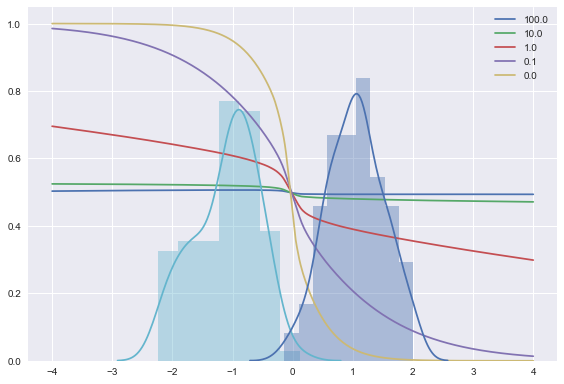

In [6]:
gp_coef = [100., 10., 1., 1e-1,0.]
fin_out = list()
test_input = torch.Tensor(np.linspace(-4,4,400))

for c in gp_coef:
    print(c)
    d = D()
    optimizer = torch.optim.Adam(d.parameters(),lr=1e-4)
    for epoch in range(100):
        loss = train(epoch, d, optimizer, coef=c)
    print(loss)
    # If you use Vanilla GAN loss
    test_output = torch.sigmoid(d(test_input)).squeeze(1).detach().numpy()
    # elif you use WGAN loss
#     test_output = d(test_input).squeeze(1).detach().numpy()
    fin_out.append(test_output)
    
for i, coef in enumerate(gp_coef):
    plt.plot(np.linspace(-4,4,400),fin_out[i], label=str(coef))
sns.distplot(origin_data.detach())
sns.distplot(fake_data.detach())
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
def train(epoch, net, optimizer, real_data=origin_data, fake_data=fake_data, coef=10.):
    running_loss = 0.0
    # get the inputs
    real_data.requires_grad_(True)
    fake_data.requires_grad_(True)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    d_r = net(real_data)
    d_f = net(fake_data)
    # choice 1 : Vanilla GAN loss
    loss_d = torch.mean(-torch.log(torch.sigmoid(d_r))) \
    + torch.mean(-torch.log(1-torch.sigmoid(d_f)))
    
    # choice 2 : WGAN loss
#     loss_d = torch.mean(-d_r) + torch.mean(d_f)
    
    # calc gp
    # choice 1 : zero-centered GP
#     grad_r = autograd.grad(d_r, real_data,
#                        grad_outputs=torch.ones_like(d_r),
#                        allow_unused=True, 
#                        create_graph=True, 
#                        retain_graph=True)[0].view(d_r.size(0),-1)
#     grad_f = autograd.grad(d_f, fake_data,
#                        grad_outputs=torch.ones_like(d_f),
#                        allow_unused=True, 
#                        create_graph=True, 
#                        retain_graph=True)[0].view(d_f.size(0),-1)
#     loss_gp = torch.mean(grad_r.norm(dim=1,p=2)**2) + torch.mean(grad_f.norm(dim=1,p=2)**2)
    
    # choice 2 : zero-centered mixed GP
    u = torch.rand(d_f.size(0))
    mix_data = u*real_data + (1-u)*fake_data
    d_mix = net(mix_data)
    grad_mix = autograd.grad(d_mix, mix_data,
                           grad_outputs=torch.ones_like(d_mix),
                           allow_unused=True, 
                           create_graph=True, 
                           retain_graph=True)[0].view(d_mix.size(0),-1)
    loss_gp = torch.mean(grad_mix.norm(dim=1,p=2)**2)
    
    loss = loss_d + coef*loss_gp
    loss.backward()
    optimizer.step()
    

    # print statistics
    running_loss += loss_d.item()
    if (epoch+1) % 1000 == 0:
        print('[Epoch : %d] loss: %.3f' %
              (epoch + 1, running_loss))
    return running_loss

100.0
1.3812211751937866
10.0
1.3291113376617432
1.0
1.0158259868621826
0.1
0.43658486008644104
0.0
0.16700391471385956


/Users/SungYub/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


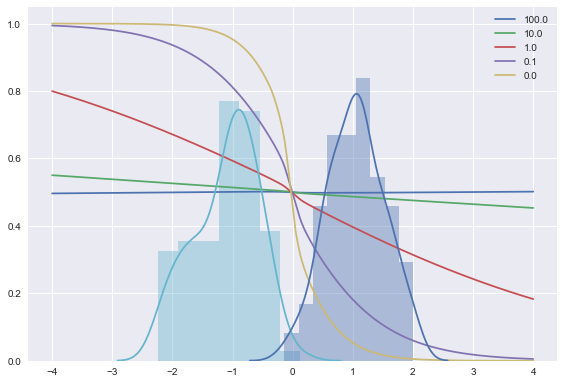

In [8]:
gp_coef = [100., 10., 1., 1e-1,0.]
fin_out = list()
test_input = torch.Tensor(np.linspace(-4,4,400))

for c in gp_coef:
    print(c)
    d = D()
    optimizer = torch.optim.Adam(d.parameters(),lr=1e-4)
    for epoch in range(100):
        loss = train(epoch, d, optimizer, coef=c)
    print(loss)
    # If you use Vanilla GAN loss
    test_output = torch.sigmoid(d(test_input)).squeeze(1).detach().numpy()
    # elif you use WGAN loss
#     test_output = d(test_input).squeeze(1).detach().numpy()
    fin_out.append(test_output)
    
for i, coef in enumerate(gp_coef):
    plt.plot(np.linspace(-4,4,400),fin_out[i], label=str(coef))
sns.distplot(origin_data.detach())
sns.distplot(fake_data.detach())
plt.legend()
plt.tight_layout()
plt.show()